In [1]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import random

In [2]:
def randomized_img(path, num_images=10):
    files = [i for i in os.listdir(path) if i.lower().endswith(('png', 'jpg', 'jpeg'))]
    selected = random.sample(files, min(num_images, len(files)))
    return [os.path.join(path, file) for file in selected]

def display_images_grid(image_paths, grid_size=(2, 5)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 6))
    axes = axes.flatten()
    
    for ax, img_path in zip(axes, image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path))
        ax.axis('off')
    
    for ax in axes[len(image_paths):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Dataset Preview

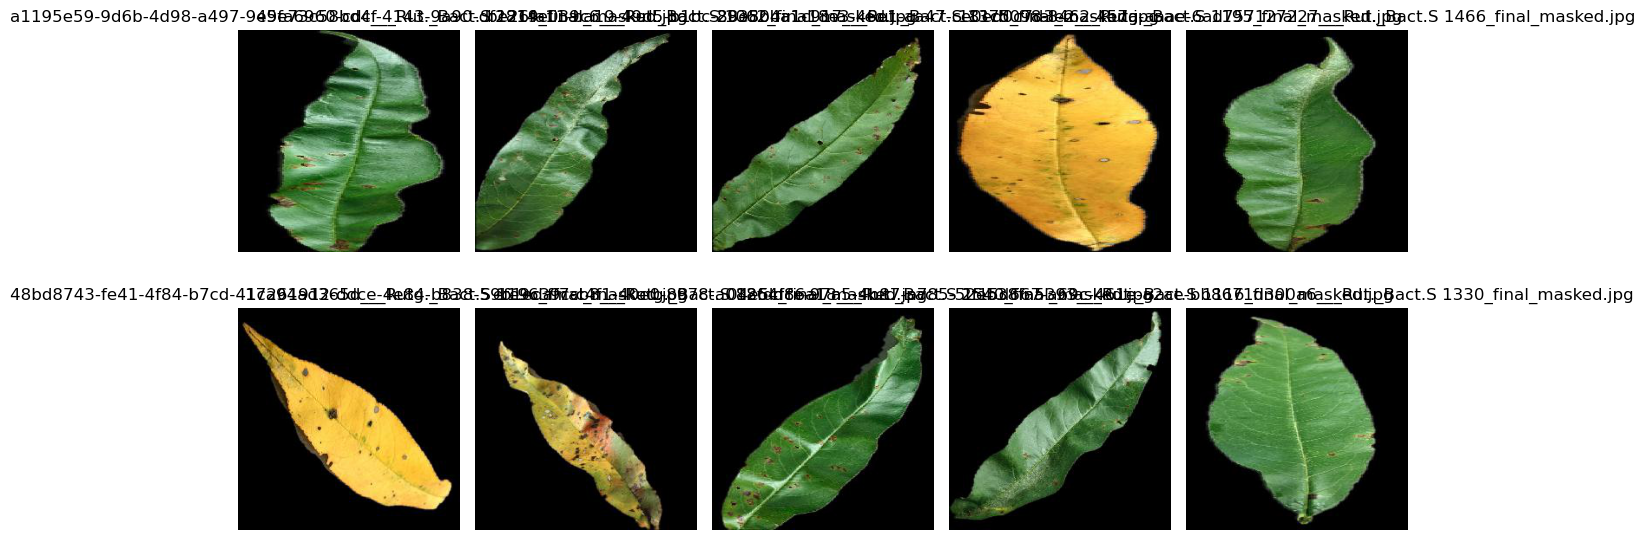

In [3]:
folder_path = "raw/segmented/Peach___Bacterial_spot"
image_paths = randomized_img(folder_path, num_images=10)
display_images_grid(image_paths)

# Image Segmentation

In [4]:
def display_segmented(image_paths, grid_size=(2, 5)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 6))
    axes = axes.flatten()
    path_list = []
    
    for ax, img_path in zip(axes, image_paths):
        image = cv2.imread(img_path)                                # open the image
        image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)           # convert to RGB 
        image_hsv = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2HSV)       # convert to HSV
        mask_greenyellow = cv2.inRange(image_hsv, (0 , 0, 0), (85, 255, 255))   # choose the HSV range to make the mask
        mask_brown = cv2.inRange(image_hsv, (15, 0, 0), (25, 255, 150))
        mask = cv2.bitwise_or(mask_greenyellow,mask_brown)
        kernel = np.ones((10, 10),np.uint8)                         #kernel necessary for the morphology
        mask_morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_3ch = cv2.cvtColor(mask_morph, cv2.COLOR_GRAY2BGR)     # convert the mask to 3 channels
        foreground = cv2.bitwise_and(image_rgb, mask_3ch)           # remove the background
        image_bgr = cv2.cvtColor(foreground,cv2.COLOR_RGB2BGR)

        # Save the image to a folder
        filename = os.path.basename(img_path)
        save_path = os.path.join("segmented/", filename)
        cv2.imwrite(save_path, image_bgr)
        path_list.append(save_path)

        ax.imshow(foreground)                                       # show the images with removed background
        ax.set_title(os.path.basename(img_path))
        ax.axis('off')
    
    for ax in axes[len(image_paths):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    return path_list

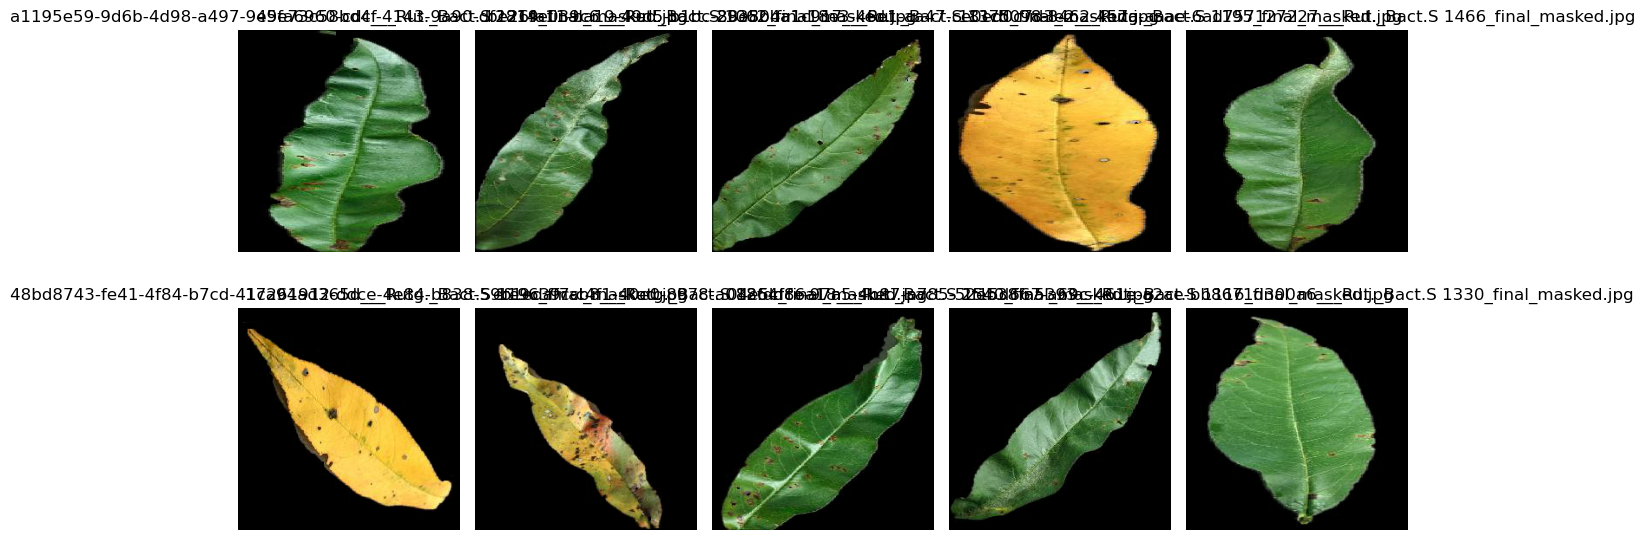

In [5]:
# Display
segmented_list = display_segmented(image_paths)

# Crop based on colour 1


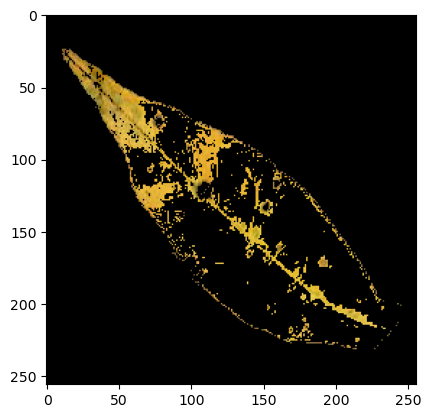

In [6]:
image1 = cv2.imread(segmented_list[5])
image1rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
mask_crop = cv2.inRange(image1rgb, (110,90 ,5),(240,210,90))
foreground_yellowbrown = cv2.bitwise_and(image1rgb, image1rgb, mask =mask_crop)


plt.imshow(foreground_yellowbrown, cmap= 'gray')


# Crop based on color 2

In [13]:
def dominateColor(images):
    v = []
    # images_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    # mask_mean = cv2.inRange(images, (2,2,2), (255,255,255))
    # red_value = cv2.mean(images,mask = mask_mean)[0:1]
    # green_value = cv2.mean(images,mask = mask_mean)[1:2]
    # blue_value = cv2.mean(images,mask = mask_mean)[2:3]
    # v.extend([red_value, green_value, blue_value])
    image_hsv = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)
    mask_mean = cv2.inRange(images, (2,2,2), (255,255,255))
    hue = cv2.mean(images,mask = mask_mean)[0:1]
    saturation = cv2.mean(images,mask = mask_mean)[1:2]
    value = cv2.mean(images,mask = mask_mean)[2:3]
    v.extend([hue, saturation, value])
    return v

def detect_leaf(img):
    image = cv2.imread(img)
    kernel = np.ones((7, 7), np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
    mask_yellow_green = cv2.inRange(hsv, (10, 39, 64), (86, 255, 255))
    mask = cv2.bitwise_or(mask_yellow_green, mask_brown)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

def display_leaves(image_paths, grid_size=(2, 5)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 6))
    axes = axes.flatten()
    # path_list = []

    for ax, img_path in zip(axes, image_paths):

        image = cv2.imread(img_path)
        mask = detect_leaf(img_path)
        image_masked = cv2.bitwise_and(image1,image1, mask=mask) # I apply the mask
        image_masked_hsv = cv2.cvtColor(image_masked, cv2.COLOR_BGR2HSV) # image masked is converted in RGB image
        array_hsv_mean = dominateColor(image_masked_hsv)
         # Check the damage using the color
        if (40 <= array_hsv_mean[0][0]<= 85) and (40 <= array_hsv_mean[1][0]<= 255) and (40 <= array_hsv_mean[2][0]<= 255):
            status = 'The leaf is healthy'            
        else: 
            status = 'The leaf is damaged'
        print(status)
        ax.imshow(image)                                       
        ax.set_title(status)
        ax.axis('off')
    
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


#leaves_list = display_leaves(segmented_list, grid_size=(2, 5))


# mask = detect_leaf(image1)
# image_masked = cv2.bitwise_and(image1,image1, mask=mask) # I apply the mask
# image_masked_hsv = cv2.cvtColor(image_masked, cv2.COLOR_BGR2HSV) # image masked is converted in RGB image
# array_hsv_mean = dominateColor(image_masked_hsv)

# #Check the damage using the color
# if (40 <= array_hsv_mean[0][0]<= 85) and (40 <= array_hsv_mean[1][0]<= 255) and (40 <= array_hsv_mean[2][0]<= 255):
#     print('The leaf is healthy')
# else: 
#     print('The leaf is damaged')
# plt.imshow(image_masked_hsv,cmap = 'gray')
# print(array_hsv_mean)


In [33]:
print(v)
#plt.stairs(histogram,bin_edges, fill=True)

[(69.28909952606635,), (158.11685097419695,), (166.13680884676145,)]


The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged
The leaf is damaged


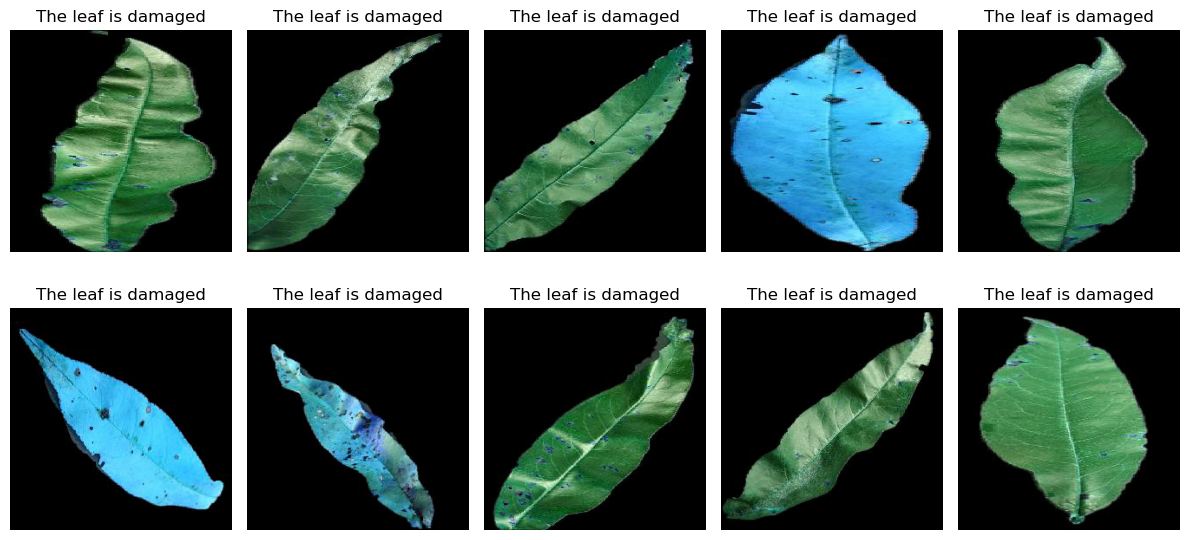

In [14]:
display_leaves(segmented_list)

# Mean 

(75.46891816663575, 167.05443186738418, 162.37539432176658)
The leaf is healty


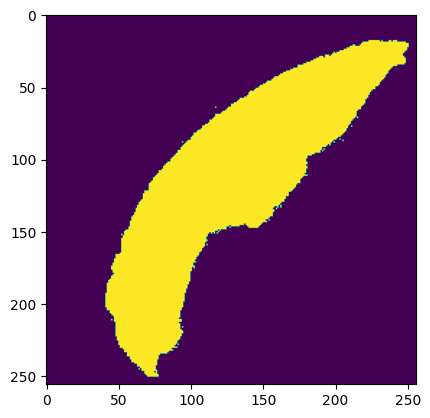

In [27]:
#def leaf_mean(image,T1,T2):  

image01 = cv2.imread(segmented_list[8])
image01_hsv = cv2.cvtColor(image01, cv2.COLOR_BGR2HSV)
mask_mean = cv2.inRange(image01, (0,0,10), (180,255,255))
mean01 = cv2.mean(image01,mask = mask_mean)[0:3]
print(mean01)
plt.imshow(mask_mean)
if mean01[0]<= 50 or mean01[0]>= 120:
    print('The leaf is damaged')
else: 
    print('The leaf is healty')


# Edge Detector

In [201]:
def display_edge(image_paths, grid_size=(2, 5)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 6))
    axes = axes.flatten()
    path_list = []
    
    for ax, img_path in zip(axes, image_paths):
        image = cv2.imread(img_path)                                # open the image
        image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)         # convert to greyscale 
        image_blur = cv2.GaussianBlur(image_gray, (15,15), 0)         # blur the image
        #sobelx = cv2.Sobel(src=image_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
        #sobely = cv2.Sobel(src=image_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
        #sobel_img = cv2.magnitude(sobelx, sobely)
        #sobel_display = cv2.convertScaleAbs(sobel_img)
        #_, sobel_edges = cv2.threshold(sobel_display, 50, 255, cv2.THRESH_BINARY)
        canny = cv2.Canny(image=image_blur, threshold1=30, threshold2=80)

        ax.imshow(canny, cmap='grey')                                       # show the images with removed background
        ax.set_title(os.path.basename(img_path))
        ax.axis('off')

        # Save the image to a folder
        filename = os.path.basename(img_path)
        save_path = os.path.join("canny/", filename)
        cv2.imwrite(save_path, canny)
        path_list.append(save_path)

        print(save_path)
    
    for ax in axes[len(image_paths):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    return path_list

canny/f9387df3-a240-43ba-9c75-552f74a3cf85___Rut._Bact.S 1299_final_masked.jpg
canny/3ee4f7e9-fd61-4714-a59d-ff100c9e8aff___Rutg._Bact.S 1633_final_masked.jpg
canny/413ac1e6-a5f1-411c-b610-81b8290bbed2___Rutg._Bact.S 1849_final_masked.jpg
canny/5d2ecb1d-779a-4b7c-b072-4c8eb2ef9d7c___Rut._Bact.S 1281_final_masked.jpg
canny/f71a12c5-2bd1-4f10-a132-3ab8631530e7___Rutg._Bact.S 1422_final_masked.jpg
canny/1f214af7-0515-4b9f-acf7-26ad58da9c94___Rutg._Bact.S 2326_final_masked.jpg
canny/372b421c-b1b4-4f6e-abcc-9f85b479f5e5___Rut._Bact.S 1382_final_masked.jpg
canny/1008c408-e2ce-43b7-bc2b-2daa4bd31487___Rutg._Bact.S 1576_final_masked.jpg
canny/f8278fdf-ed93-4f76-93d3-262b23c6fa12___Rutg._Bact.S 2200_final_masked.jpg
canny/8fdb88c2-0f5b-4438-9598-d46135e0a843___Rut._Bact.S 3382_final_masked.jpg


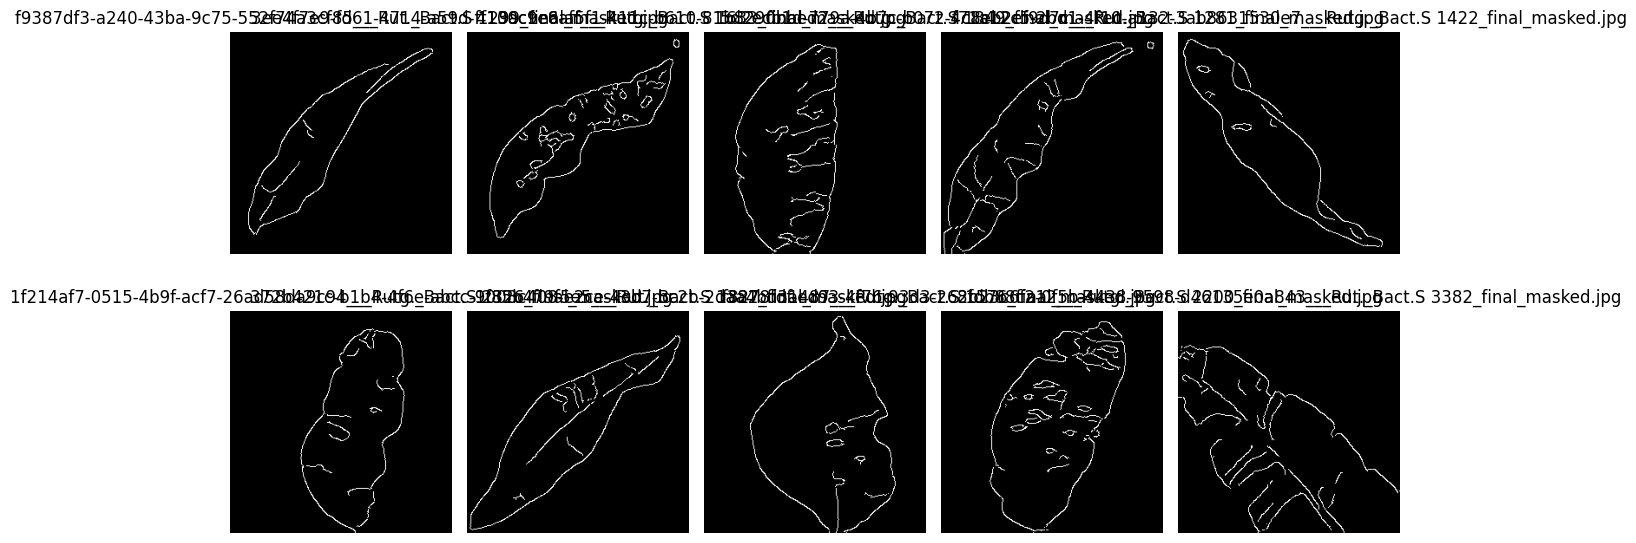

In [202]:
canny_list = display_edge(segmented_list)

In [203]:
canny_list[0]

'canny/f9387df3-a240-43ba-9c75-552f74a3cf85___Rut._Bact.S 1299_final_masked.jpg'